### Papers 

- [Predicting the properties of black holes merger remnants with Deep Neural Networks](https://arxiv.org/abs/1911.01496)
- [The SXS Collaboration catalog of binary black hole simulations](https://arxiv.org/abs/1904.04831)
- [Deep Learning for Real-time Gravitational Wave Detection and Parameter Estimation: Results with Advanced LIGO Data](https://arxiv.org/abs/1711.03121)

- NEW ONE: [GWTC-3: Compact Binary Coalescences Observed by LIGO and Virgo During the Second Part of the Third Observing Run](https://arxiv.org/abs/2111.03606)

### Other Links 

- [SXS Collaboration catalog](https://data.black-holes.org/waveforms/index.html)
- [Github repo of SXS Collaboration catalog](https://github.com/sxs-collaboration/catalog_tools)
- [Rit catalog](https://ccrg.rit.edu/content/data/rit-waveform-catalog)
- [lal simulation](https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/classlalsimulation_1_1nrfits_1_1_n_r_sur7dq4_remnant_1_1_n_r_sur7dq4_remnant.html)
- [Visualizations](https://vijayvarma392.github.io/SurrogateMovie)


## To do 

**@David**
- Outliers: check the ones w remnant_mass > 1.5, and the ones with m1+m2 < 1


**@Cami**
- Preprocessing: feat eng
- Apply model from paper
- User stratified sampling? 

**Extra** 
- Extract all data and check that all simulations have the same data over time
- Use Monte Carlo to include error in the mass ratio


In [1]:
import numpy as np
import pandas as pd
import random
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import itertools
import h5py
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing import image
#from keras.applications import resnet50


Using TensorFlow backend.


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Input data: Virgo 
1. Explore dataframe (columns, summary stats, visualizations)
2. Clean dataframe (remove non BBHs)
3. Build new features

Note: we have to delete two obs that are neutron stars: 
In addition to GW200115 042309 and GW200105 162426, the O3b candidates include GW191219 163120 that is consistent with originating from a NSBH, and GW200210 092254 that could either be from a NSBH or a binary black hole (BBH)

In [4]:
virgo = pd.read_csv('GWTC.csv')

In [5]:
virgo.shape

(93, 40)

### 1. 

In [6]:
virgo.columns

Index(['id', 'commonName', 'version', 'catalog.shortName', 'GPS', 'reference',
       'jsonurl', 'mass_1_source', 'mass_1_source_lower',
       'mass_1_source_upper', 'mass_2_source', 'mass_2_source_lower',
       'mass_2_source_upper', 'network_matched_filter_snr',
       'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper',
       'luminosity_distance', 'luminosity_distance_lower',
       'luminosity_distance_upper', 'chi_eff', 'chi_eff_lower',
       'chi_eff_upper', 'total_mass_source', 'total_mass_source_lower',
       'total_mass_source_upper', 'chirp_mass_source',
       'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass',
       'chirp_mass_lower', 'chirp_mass_upper', 'redshift', 'redshift_lower',
       'redshift_upper', 'far', 'far_lower', 'far_upper', 'final_mass_source',
       'final_mass_source_lower', 'final_mass_source_upper'],
      dtype='object')

In [7]:
virgo.tail(2)

,id,commonName,version,catalog.shortName,GPS,reference,jsonurl,mass_1_source,mass_1_source_lower,mass_1_source_upper,mass_2_source,mass_2_source_lower,mass_2_source_upper,network_matched_filter_snr,network_matched_filter_snr_lower,network_matched_filter_snr_upper,luminosity_distance,luminosity_distance_lower,luminosity_distance_upper,chi_eff,chi_eff_lower,chi_eff_upper,total_mass_source,total_mass_source_lower,total_mass_source_upper,chirp_mass_source,chirp_mass_source_lower,chirp_mass_source_upper,chirp_mass,chirp_mass_lower,chirp_mass_upper,redshift,redshift_lower,redshift_upper,far,far_lower,far_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
91,GW200316_215756-v1,GW200316_215756,1,GWTC-3-confident,1.268431e+09,/GWTC-3/,https://www.gw-openscience.org/eventapi/json/G...,13.1,-2.9,10.2,7.8,-2.9,1.9,10.3,-0.7,0.4,1120.0,-440.0,470.0,0.13,-0.10,0.27,21.2,-2.0,7.2,8.75,-0.55,0.62,NaN,NaN,NaN,0.22,-0.08,0.08,0.00001,NaN,NaN,20.2,-1.9,7.4
92,GW200322_091133-v1,GW200322_091133,1,GWTC-3-confident,1.268904e+09,/GWTC-3/,https://www.gw-openscience.org/eventapi/json/G...,34.0,-18.0,48.0,14.0,-8.7,16.8,6.0,-1.2,1.7,3600.0,-2000.0,7000.0,0.24,-0.51,0.45,55.0,-27.0,37.0,15.50,-3.70,15.70,NaN,NaN,NaN,0.60,-0.30,0.84,140.00000,NaN,NaN,53.0,-26.0,38.0


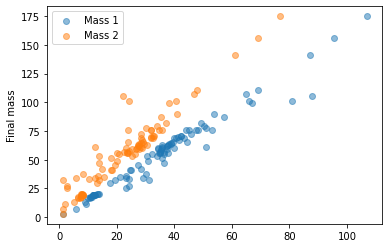

In [8]:
#See how initial mass 1 and initiall mass 2 relate to final mass 
plt.scatter(virgo.mass_1_source, virgo.final_mass_source, label='Mass 1' , alpha = 0.5)
plt.scatter(virgo.mass_2_source, virgo.final_mass_source, label='Mass 2' , alpha = 0.5)
plt.ylabel('Final mass')
plt.legend()
plt.show()

### 2. Pending: to clean 

### 3. Build features: Pending to see what is comparable with LIGO. 
- The scatter plot from above with Mass 1 and Mass 2 versus Final Mass is very linear, in LiGO it was more of a curve. 

### Input data: Catalog.json

1. Explore dataframe (columns, summary stats, visualizations)
2. Clean dataframe (remove non BBHs)
3. Build new features

### 1.

In [9]:
df = pd.read_json('catalog.json')


In [10]:
df.columns

Index(['url', 'simulation_name', 'alternative_names', 'initial_data_type',
       'object_types', 'number_of_orbits', 'reference_mass_ratio',
       'reference_chi_eff', 'reference_chi1_perp', 'reference_chi2_perp',
       'reference_eccentricity', 'reference_dimensionless_spin1',
       'reference_dimensionless_spin2', 'reference_orbital_frequency',
       'reference_mass1', 'reference_mass2', 'reference_time',
       'reference_position1', 'reference_position2', 'reference_mean_anomaly',
       'keywords', 'point_of_contact_email', 'authors_emails',
       'simulation_bibtex_keys', 'code_bibtex_keys',
       'initial_data_bibtex_keys', 'quasicircular_bibtex_keys',
       'initial_separation', 'initial_orbital_frequency', 'initial_adot',
       'object1', 'object2', 'initial_ADM_energy',
       'initial_ADM_linear_momentum', 'initial_ADM_angular_momentum',
       'initial_mass1', 'initial_mass2', 'initial_dimensionless_spin1',
       'initial_dimensionless_spin2', 'initial_position1',

In [11]:
df.head(2)

,url,simulation_name,alternative_names,initial_data_type,object_types,number_of_orbits,reference_mass_ratio,reference_chi_eff,reference_chi1_perp,reference_chi2_perp,reference_eccentricity,reference_dimensionless_spin1,reference_dimensionless_spin2,reference_orbital_frequency,reference_mass1,reference_mass2,reference_time,reference_position1,reference_position2,reference_mean_anomaly,keywords,point_of_contact_email,authors_emails,simulation_bibtex_keys,code_bibtex_keys,initial_data_bibtex_keys,quasicircular_bibtex_keys,initial_separation,initial_orbital_frequency,initial_adot,object1,object2,initial_ADM_energy,initial_ADM_linear_momentum,initial_ADM_angular_momentum,initial_mass1,initial_mass2,initial_dimensionless_spin1,initial_dimensionless_spin2,initial_position1,initial_position2,relaxation_time,common_horizon_time,remnant_mass,remnant_dimensionless_spin,remnant_velocity,metadata_version,spec_revisions,spells_revision,com_parameters,initial_mass_ratio,metadata_path,name,eos,merger_time,final_time,disk_mass,ejecta_mass,reference_spin1,reference_spin2,nitial_spin1,initial_spin2,remnant_spin,initial_mass_withspin2
0,https://doi.org/10.5281/zenodo.1212426,d18.0_q1.0_s0_0_0_s0_0_0/Lev5,SXS:BBH:0001,BBH_CFMS,BHBH,28.119083,1.0,1.215639e-07,9.733309e-10,1.429939e-09,0.0002569,"[7.09752141352e-10, -6.66051760901e-10, 1.2093...","[5.84453420303e-10, 1.3050444511300001e-09, 1....","[2.8280852361099996e-13, -8.251591712050001e-1...",0.5,0.5,320.0,"[-6.4605628809799995, -6.21953367941, -3.37886...","[6.46056317772, 6.21953399104, 2.00589477099e-10]",3.083240,"[Non-Spinning, ManyMergers-QuasiCircular]",mroue@cita.utoronto.ca,"[Mike Boyle <boyle@astro.cornell.edu>, Dan Hem...","[Mroue:2013xna, Boyle:2019kee, SXSCatalogWebsite]","[Ossokine:2013zga, Hemberger:2012jz, Szilagyi:...","[Buchman:2012dw, Lovelace:2008tw, Pfeiffer:200...","[Mroue:2012kv, Buonanno:2010yk, Mroue:2010re, ...",18.0,0.012203,-0.000025,bh,bh,0.993736,"[7.5160071e-09, 2.4389069e-09, -5.798632e-10]","[4.27581822e-08, -2.3426250729999996e-07, 1.18...",0.5,0.5,"[-6.35700000002e-13, 4.72400000001e-13, 1.0250...","[4.4999999999800006e-15, -2.8e-15, 1.559379999...","[9.000000125802465, -2.8664642100000002e-08, 0]","[-8.999999874197535, -2.8664642100000002e-08, 0]",320.0,9524.085983,0.951609,"[-7.29520687012e-10, 7.40468371215e-10, 0.6864...","[1.45734870604e-09, 7.51603528474e-10, 3.72053...",1,"[InitialCommit-20603-g8a2e9b6, InitialCommit-2...",InitialCommit-21848-g8d8a7d7,"{'space_translation': [3.6668214400000003e-08,...",1.0,SXS:BBH:0001v6/Lev5/metadata.json,SXS:BBH:0001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://doi.org/10.5281/zenodo.1210580,d19.0_q1.0_s0_0_0_s0_0_0/Lev6,SXS:BBH:0002,BBH_CFMS,BHBH,32.421068,1.0,9.399402e-08,7.181763e-10,1.473155e-09,0.0001746,"[6.50756283834e-10, -3.03798339473e-10, 9.4840...","[1.0426889812e-09, 1.04066536466e-09, 9.314798...","[2.20978373119e-13, -7.93686620079e-13, 0.0113...",0.5,0.5,310.0,"[-8.87345009522, -3.32815913214, 1.74403931592...","[8.87345005146, 3.32815888263, 2.94462584419e-10]",2.514884,"[Non-Spinning, ManyMergers-QuasiCircular]",mroue@cita.utoronto.ca,"[Mike Boyle <boyle@astro.cornell.edu>, Dan Hem...","[Mroue:2013xna, Boyle:2019kee, SXSCatalogWebsite]","[Ossokine:2013zga, Hemberger:2012jz, Szilagyi:...","[Buchman:2012dw, Lovelace:2008tw, Pfeiffer:200...","[Mroue:2012kv, Buonanno:2010yk, Mroue:2010re, ...",19.0,0.011292,-0.000021,bh,bh,0.994031,"[1.6810827e-09, 1.4244131e-09, -1.148397590000...","[2.7620419800000002e-06, -2.428793193e-06, 1.2...",0.5,0.5,"[5.319329999989999e-11, -6.31285000002e-11, -1...","[-3.268359e-10, 2.252065e-10, -1.44598159e-08]","[9.50000028134381, 2.0830027e-07, 0]","[-9.49999971865619, 2.0830027e-07, 0]",310.0,11804.749017,0.95161,"[3.7521879808300004e-10, 1.3261440201800001e-0...","[3.5996348603100005e-09, 7.181410030280001e-09...",1,"[InitialCommit-20603-g8a2e9b6, InitialCommit-2...",InitialCommit-21848-g8d8a7d7,"{'space_translation': [-4.66496816e-08, 2.4388...",1.0,SXS:BBH:000

#### Exploring "Keywords" 

In [12]:
df[['keyword1','keyword2','keyword3']] = pd.DataFrame(df.keywords.tolist(), index= df.index)

In [13]:
df.keyword1.value_counts(dropna=False)

NaN                 1845
Precessing-Spins      91
Aligned-Spins         51
Non-Spinning          35
NonSpinning            4
SpinningNS             2
Name: keyword1, dtype: int64

In [14]:
df.keyword2.value_counts(dropna=False)

NaN                          1845
ManyMergers-QuasiCircular      80
ManyMergers-Eccentric          43
ManyMergers-Random32           32
ManyMergers-SKS                19
Polytrope                       8
PiecewisePolytrope              1
Name: keyword2, dtype: int64

### 2. Cleaning data

In [19]:
predictors = ['alternative_names','reference_mass_ratio', 'reference_dimensionless_spin1',
              'reference_dimensionless_spin2','remnant_mass','remnant_dimensionless_spin',
              'keyword1','keyword2','keyword3',
              'reference_chi_eff', 'reference_chi1_perp', 'reference_chi2_perp',
               'reference_mass1', 'reference_mass2'
             ]

In [20]:
# Removing rows with NA values
df_ok = df.loc[0:2018, predictors]

In [21]:
# Removing rows with outliers on remnant_mass
df_ok = df_ok.loc[df_ok.remnant_mass < 1.5,]

In [22]:
df_ok[['reference_dimensionless_spin1_1','reference_dimensionless_spin1_2','reference_dimensionless_spin1_3']] = pd.DataFrame(df_ok.reference_dimensionless_spin1.tolist(), index= df_ok.index)
df_ok[['reference_dimensionless_spin2_1','reference_dimensionless_spin2_2','reference_dimensionless_spin2_3']] = pd.DataFrame(df_ok.reference_dimensionless_spin2.tolist(), index= df_ok.index)
df_ok[['remnant_dimensionless_spin_1','remnant_dimensionless_spin_2','remnant_dimensionless_spin_3']] = pd.DataFrame(df_ok.remnant_dimensionless_spin.tolist(), index= df_ok.index)


### 3. Building Features 
- Adding Flags: Precessing, Not Spinning

In [23]:
df_ok['precessing'] = 1
df_ok.loc[abs(df_ok.reference_dimensionless_spin1_1) < 0.000001, 'precessing'] = 0


df_ok['notspinning'] = 0
df_ok.loc[(abs(df_ok.reference_dimensionless_spin1_1) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin1_2) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin1_3) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin2_1) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin2_2) < 0.0001) &
          (abs(df_ok.reference_dimensionless_spin2_3) < 0.0001) 
          , 'notspinning'] = 1


In [24]:
df_ok['notspinning'].value_counts()

0    1912
1     104
Name: notspinning, dtype: int64

In [25]:
df_ok['precessing'].value_counts()

1    1421
0     595
Name: precessing, dtype: int64

### Variables into the model: I just copied and pasted from df columns

#### X Variables
For hole 1: 
- $\chi_{1.1}$ = reference_dimensionless_spin1_1
- $\chi_{1.2}$ = reference_dimensionless_spin1_2
- $\chi_{1.2}$ = reference_dimensionless_spin1_3
- $m_2$ = reference_mass1
- reference_chi1_perp

For hole 2: 
- $\chi_{2.1}$ = reference_dimensionless_spin2_1
- $\chi_{2.2}$ = reference_dimensionless_spin2_2
- $\chi_{2.2}$ = reference_dimensionless_spin2_3
- $m_2$ = reference_mass2
- reference_chi2_perp


For both: 
- $q$ = reference_mass_ratio
- precessing
- not_spinning
- reference_chi_eff

#### Y (Target) Variable 
- $m_f$ = remnant_mass
- remnant_dimensionless_spin




### Calculated stats: review!!!
- $\eta$ = reference_mass_ratio / (1+reference_mass_ratio **2)
- $\eta2$ = (reference_mass1 * reference_mass2) / ((reference_mass1+reference_mass2) **2) *(is the same as eta)*

- $S_1 = |\chi_{1}|$
- $S_2 = |\chi_{2}|$
- $S_{eff} = (S1+S2)/(1−2 η M2)$
- $m_1 \:+ \:m_2 $ = reference_mass1+reference_mass2

In [33]:
df_ok['s1'] = df_ok['reference_dimensionless_spin1_1']**2 +  df_ok['reference_dimensionless_spin1_2']**2 +  df_ok['reference_dimensionless_spin1_3']**2
df_ok['s1'] = np.sqrt(df_ok['s1'])

df_ok['s2'] = df_ok['reference_dimensionless_spin2_1']**2 +  df_ok['reference_dimensionless_spin2_2']**2 +  df_ok['reference_dimensionless_spin2_3']**2
df_ok['s2'] = np.sqrt(df_ok['s2'])

In [34]:
df_ok['eta']  = df_ok['reference_mass_ratio'] / (df_ok['reference_mass_ratio']+1)**2

In [35]:
#df_ok['eta2'] = df_ok['reference_mass1'] * df_ok['reference_mass2']  / (df_ok['reference_mass1']+df_ok['reference_mass2'])**2
#df_ok[['eta','eta2']]

In [38]:
df_ok['s1_sum'] = df_ok['reference_dimensionless_spin1_1'] + df_ok['reference_dimensionless_spin2_1']
df_ok['s2_sum'] = df_ok['reference_dimensionless_spin1_2'] + df_ok['reference_dimensionless_spin2_2']
df_ok['s3_sum'] = df_ok['reference_dimensionless_spin1_3'] + df_ok['reference_dimensionless_spin2_3']
df_ok['m1+m2']  = df_ok['reference_mass1'] + df_ok['reference_mass2']
df_ok['seff'] = np.sqrt(df_ok.s1_sum**2 + df_ok.s2_sum**2 + df_ok.s3_sum**2) / (1 - (2*df_ok['eta']*df_ok['m1+m2']**2)) 

In [ ]:
df_ok.to_csv('/Users/camilaburne/UT/Data Mining/Data-Mining-ECE-280/LIGO/df_predictors.csv')

In [ ]:
df_ok.columns

### Exploratory Data Analysis 

### 3D Chart at [rpub link](https://rpubs.com/CamilaBurneUT/remnant_mass_eta_seff)

In [39]:
X = df_ok[['reference_mass_ratio',
       'reference_chi_eff',
       'reference_chi1_perp', 'reference_chi2_perp', 'reference_mass1',
       'reference_mass2', 'reference_dimensionless_spin1_1',
       'reference_dimensionless_spin1_2', 'reference_dimensionless_spin1_3',
       'reference_dimensionless_spin2_1', 'reference_dimensionless_spin2_2',
       'reference_dimensionless_spin2_3', 'precessing', 'notspinning', 's1',
       's2', 'eta', 's1_sum', 's2_sum', 's3_sum', 'm1+m2', 'seff']]

y = df_ok['remnant_mass']

y1 = df_ok['remnant_dimensionless_spin_1']
y2 = df_ok['remnant_dimensionless_spin_2']
y3 = df_ok['remnant_dimensionless_spin_3']


In [ ]:
for i in X.columns:
    plt.scatter(X[i], y, alpha = 0.2)
    plt.title(i + ' vs remnant_mass')
    plt.show()
    
    plt.scatter(X[i], y1, alpha = 0.3, color='orange')
    plt.title(i + ' vs remnant_dimensionless_spin 1 ')
    plt.show()
    plt.scatter(X[i], y2, alpha = 0.3, color='orange')
    plt.title(i + ' vs remnant_dimensionless_spin 2 ')
    plt.show()
    plt.scatter(X[i], y3, alpha = 0.3, color='orange')
    plt.title(i + ' vs remnant_dimensionless_spin 3 ')
    plt.show()

In [ ]:
plt.scatter(y, y1, alpha = 0.2, color = 'orangered')
plt.title('remnant_mass vs remnant_dimensionless_spin 1')
plt.show()
plt.scatter(y, y2, alpha = 0.2, color = 'orangered')
plt.title('remnant_mass vs remnant_dimensionless_spin 2')
plt.show()
plt.scatter(y, y3, alpha = 0.2, color = 'orangered')
plt.title('remnant_mass vs remnant_dimensionless_spin 3')
plt.show()

### Trying Stratified Sampling

In [ ]:
df_ok.columns

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

corrMatrix = df_ok.corr()
sns.heatmap(corrMatrix, annot=False)
plt.show()

In [ ]:
X = df_ok[['reference_mass_ratio',
       'reference_chi_eff',
       'reference_chi1_perp', 'reference_chi2_perp', 'reference_mass1',
       'reference_mass2', 'reference_dimensionless_spin1_1',
       'reference_dimensionless_spin1_2', 'reference_dimensionless_spin1_3',
       'reference_dimensionless_spin2_1', 'reference_dimensionless_spin2_2',
       'reference_dimensionless_spin2_3', 'precessing', 'notspinning', 's1',
       's2', 'eta', 's1_sum', 's2_sum', 's3_sum', 'm1+m2', 'seff']]

y = df_ok['remnant_mass']

y1 = df_ok['remnant_dimensionless_spin_1']
y2 = df_ok['remnant_dimensionless_spin_2']
y3 = df_ok['remnant_dimensionless_spin_3']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=df_ok[['precessing','notspinning']])

In [ ]:
X_train.precessing.value_counts(normalize=True)

In [ ]:
X_test.precessing.value_counts(normalize=True)

### From now on: Switch to the "Trying NNs" notebook
